
NaN percentage per feature:
 st_met       0.481595
st_mass      0.338190
st_logg      0.334356
st_teff      0.199770
st_rad       0.035660
sy_dist      0.025690
pl_orbper    0.009202
sy_kmag      0.005368
dtype: float64

Dropping columns with >50% NaN: []

Classification Report for Random Forest:
                precision    recall  f1-score   support

FALSE POSITIVE       0.94      0.58      0.72        59
     CONFIRMED       0.95      1.00      0.97       463

      accuracy                           0.95       522
     macro avg       0.95      0.79      0.84       522
  weighted avg       0.95      0.95      0.94       522


Classification Report for Hist Gradient Boosting:
                precision    recall  f1-score   support

FALSE POSITIVE       0.97      0.66      0.79        59
     CONFIRMED       0.96      1.00      0.98       463

      accuracy                           0.96       522
     macro avg       0.97      0.83      0.88       522
  weighted avg       0.96    

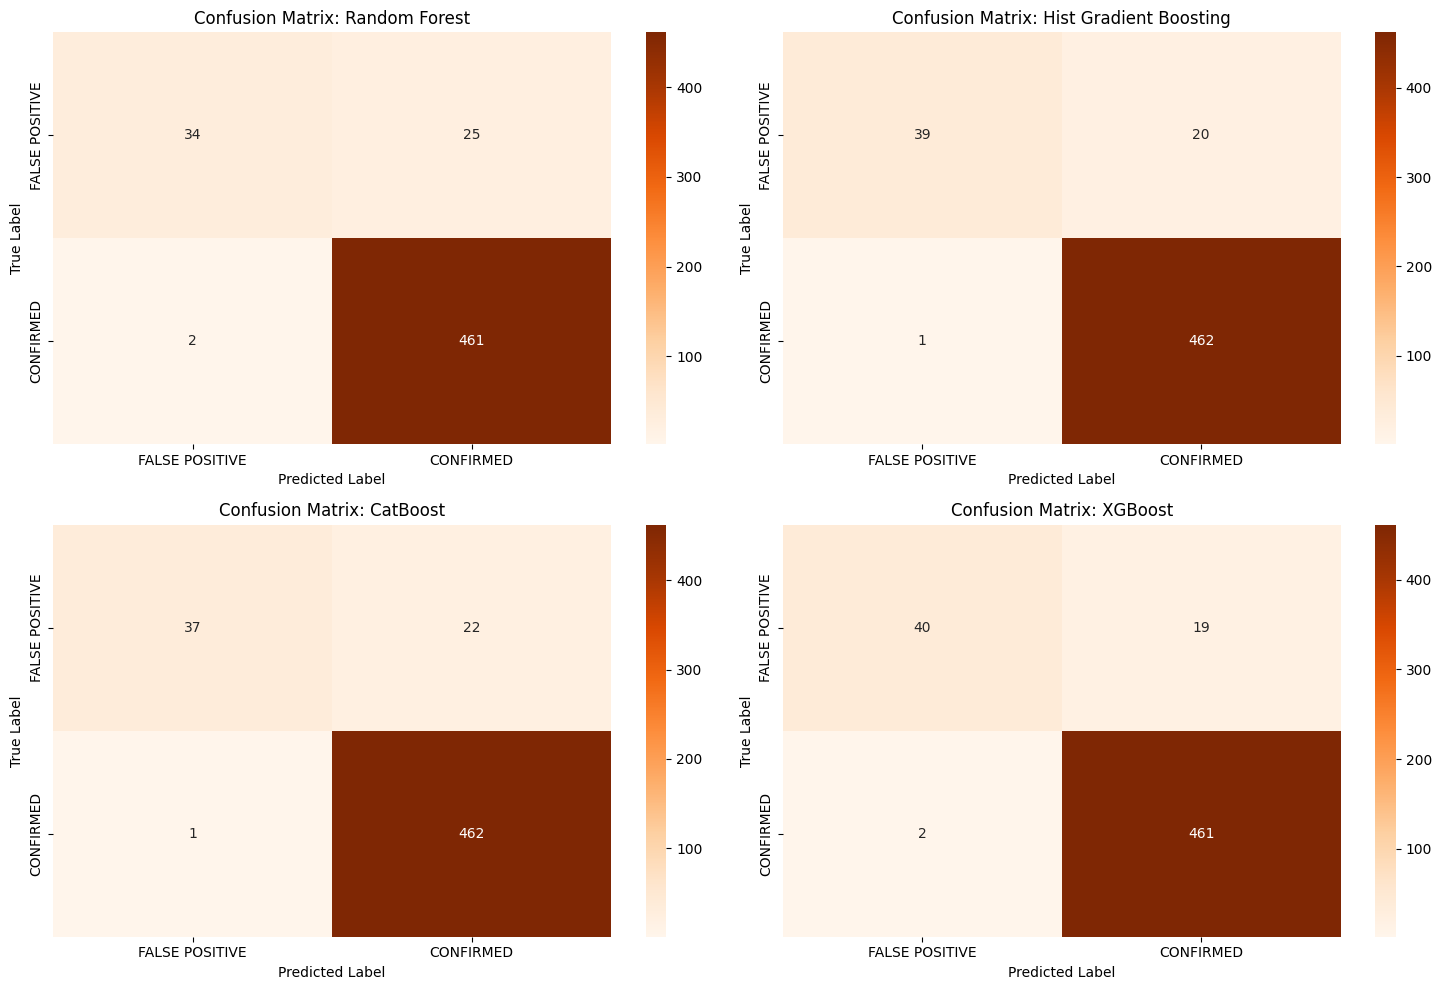

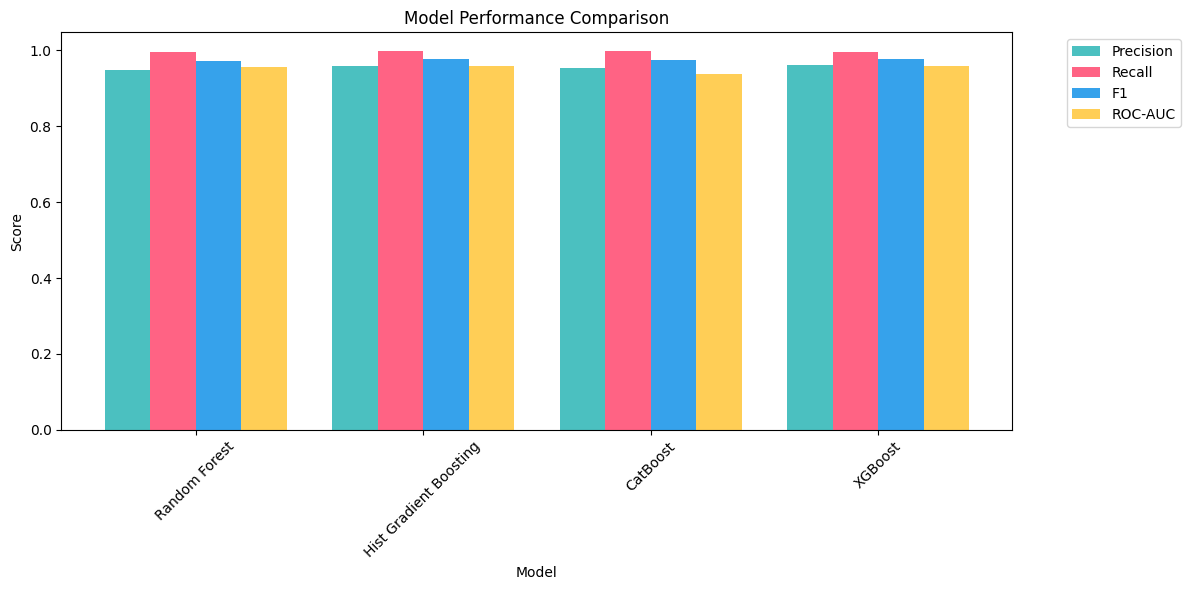

SHAP values shape: (522, 8)


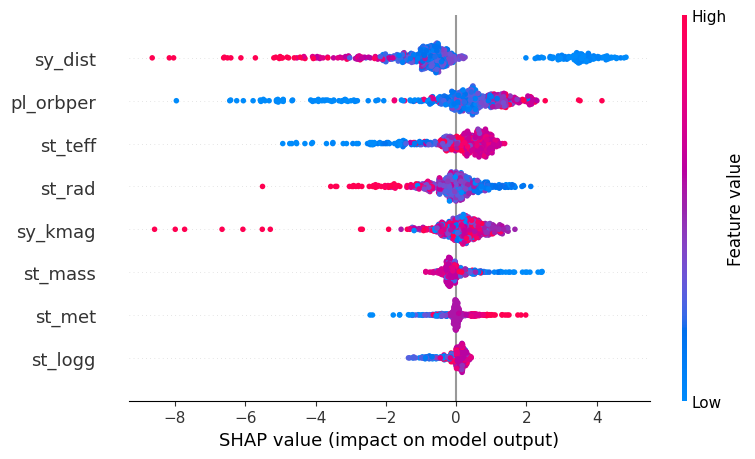


Feature correlations with target:
 target       1.000000
st_logg      0.264240
st_met       0.223570
pl_orbper    0.032513
st_teff     -0.125504
st_mass     -0.173860
sy_kmag     -0.268346
st_rad      -0.305873
sy_dist     -0.437045
Name: target, dtype: float64

Correlation of missingness with target:
 st_teff      0.074501
st_logg      0.046241
pl_orbper    0.008854
st_mass     -0.035701
sy_kmag     -0.056948
st_met      -0.089651
sy_dist     -0.103399
st_rad      -0.108376
dtype: float64

--- Model-based leakage check ---
R^2 scores: [-1.27947598  0.          0.          0.          0.        ]
Mean R^2: -0.25589519650655024
Mean R^2 on random target: -0.1326773582547069

Feature importances (permutation importance):
sy_dist: 0.629
pl_orbper: 0.436
sy_kmag: 0.307
st_teff: 0.257
st_rad: 0.242
st_logg: 0.096
st_mass: 0.050
st_met: 0.043


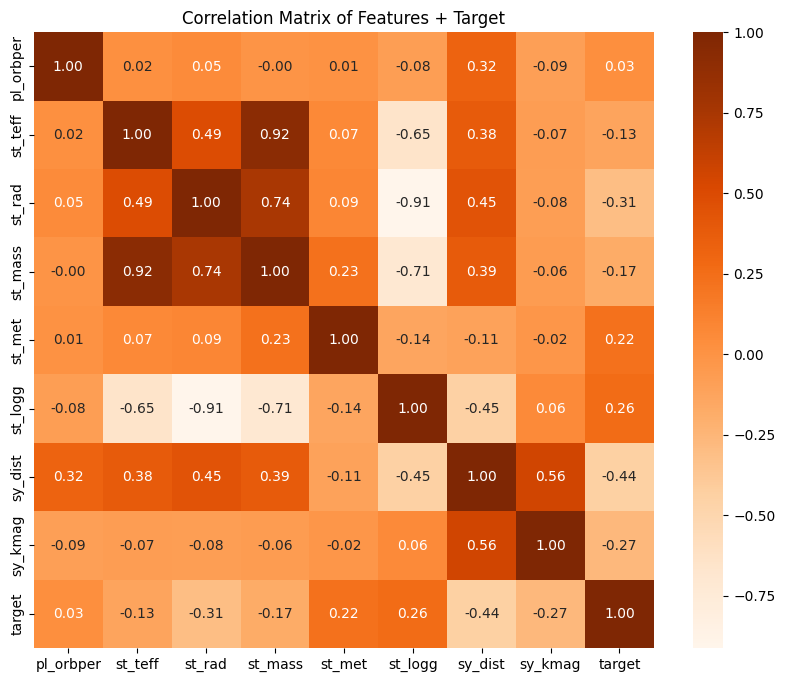

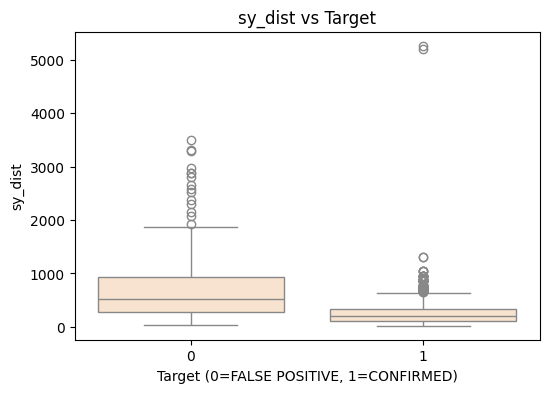

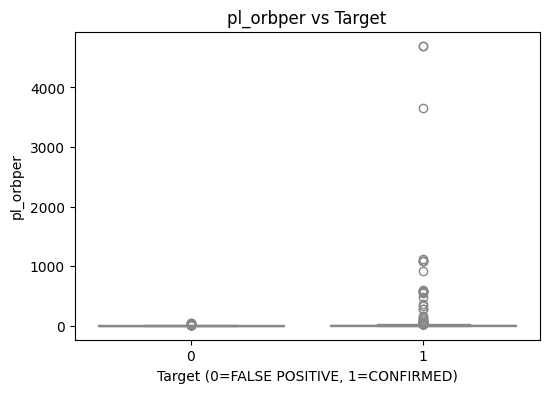

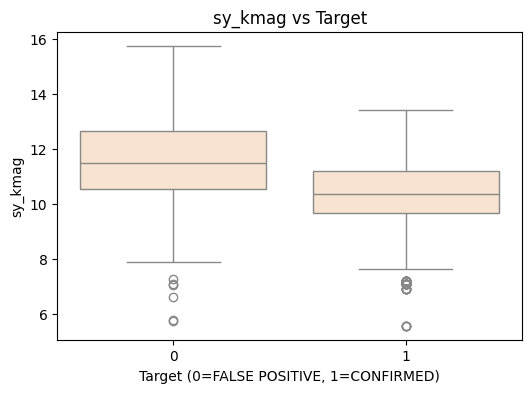

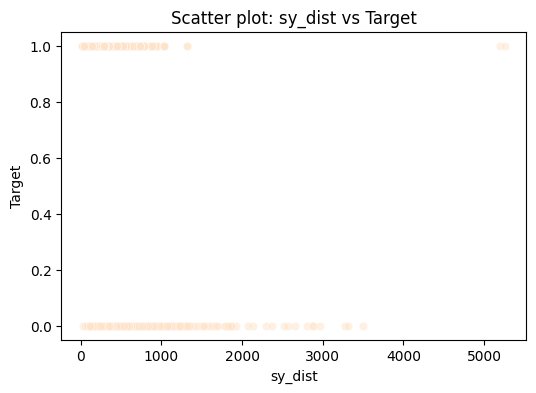

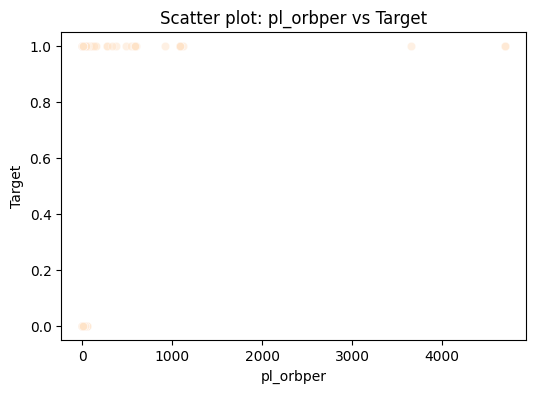

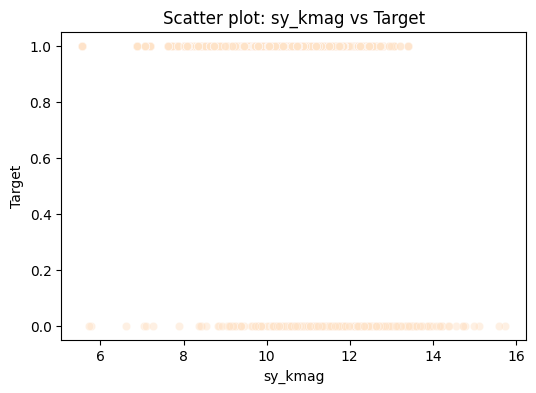

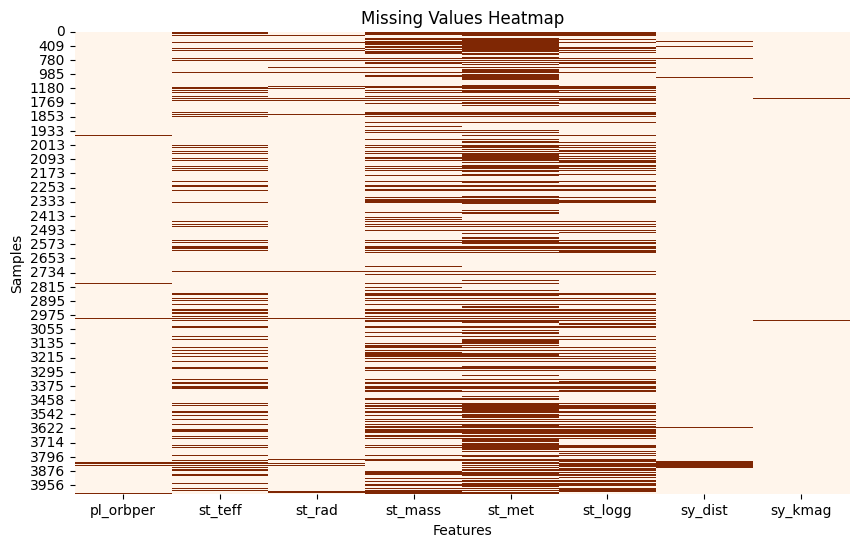

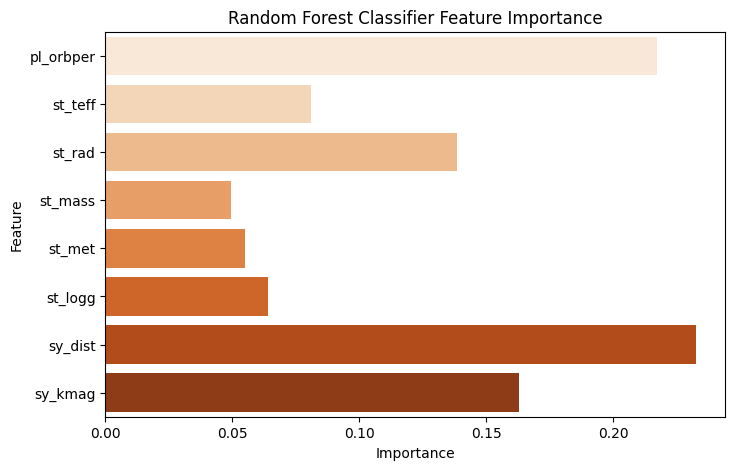

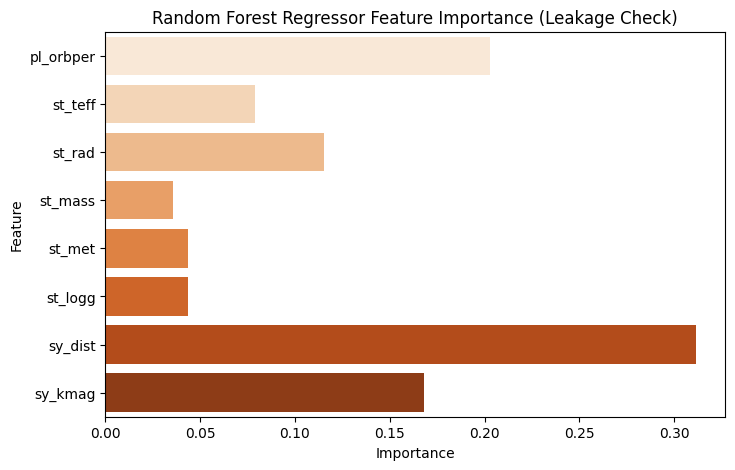

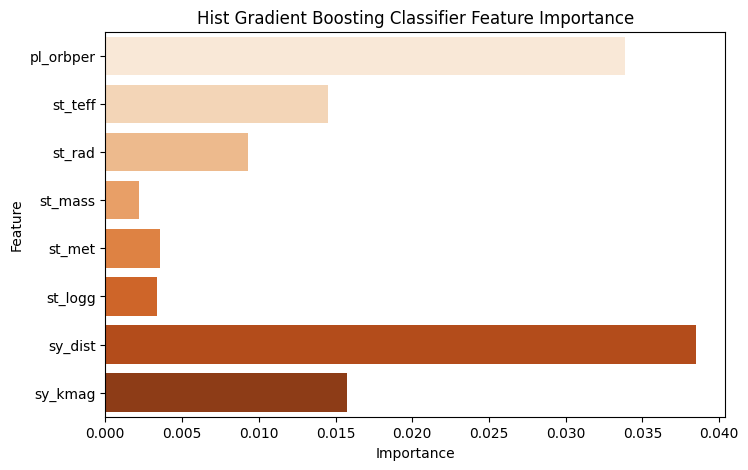

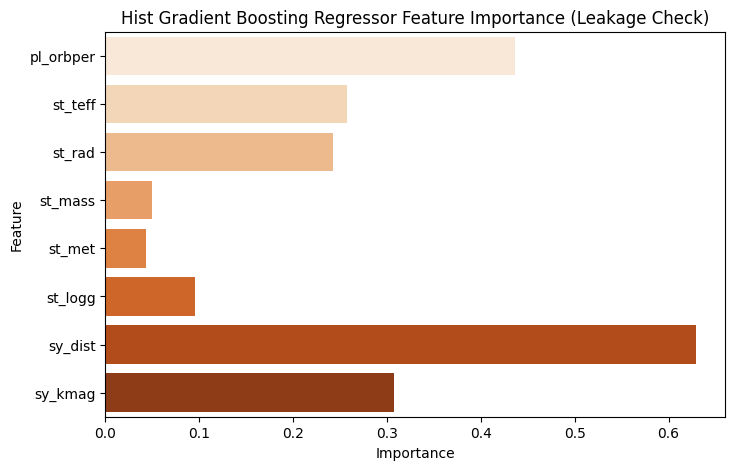

In [15]:
!pip install catboost xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

file_path = "k2pandc_2025.09.26_02.25.08.csv"
df = pd.read_csv(file_path)

df = df[df["disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])]

features = [
    "pl_orbper", "st_teff", "st_rad", "st_mass",
    "st_met", "st_logg", "sy_dist", "sy_kmag"
]

X = df[features].apply(pd.to_numeric, errors="coerce")
y = (df["disposition"] == "CONFIRMED").astype(int)  # CONFIRMED=1, FALSE POS=0

nan_pct = X.isna().mean().sort_values(ascending=False)
print("\nNaN percentage per feature:\n", nan_pct)

threshold = 0.5
drop_cols = nan_pct[nan_pct > threshold].index.tolist()
print("\nDropping columns with >50% NaN:", drop_cols)
X = X.drop(columns=drop_cols)
features = [f for f in features if f not in drop_cols]

imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train_imp, X_test_imp, _, _ = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("log", FunctionTransformer(np.log1p, validate=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, features)
])

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

models = {
    "Random Forest": rf_model,
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}

metrics = {"Model": [], "Precision": [], "Recall": [], "F1": [], "ROC-AUC": []}
confusion_matrices = {}

plt.figure(figsize=(15, 10))
for i, (name, clf) in enumerate(models.items(), 1):
    if name == "Random Forest":
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        model = clf.fit(X_train_imp, y_train)
        y_pred = model.predict(X_test_imp)
        y_proba = model.predict_proba(X_test_imp)[:, 1]

    metrics["Model"].append(name)
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1"].append(f1_score(y_test, y_pred))
    metrics["ROC-AUC"].append(roc_auc_score(y_test, y_proba))

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=["FALSE POSITIVE", "CONFIRMED"]))

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=["FALSE POSITIVE", "CONFIRMED"],
                yticklabels=["FALSE POSITIVE", "CONFIRMED"])
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metrics)
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(metrics_df["Model"]))

plt.bar(index, metrics_df["Precision"], bar_width, label="Precision", color="#4BC0C0")
plt.bar(index + bar_width, metrics_df["Recall"], bar_width, label="Recall", color="#FF6384")
plt.bar(index + 2*bar_width, metrics_df["F1"], bar_width, label="F1", color="#36A2EB")
plt.bar(index + 3*bar_width, metrics_df["ROC-AUC"], bar_width, label="ROC-AUC", color="#FFCE56")

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(index + 1.5*bar_width, metrics_df["Model"], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

hgb_model = models["Hist Gradient Boosting"]
hgb_model.fit(X_train_imp, y_train)
X_test_imp = X_test_imp[X_train_imp.columns]
explainer = shap.TreeExplainer(hgb_model, X_test_imp)
shap_values = explainer.shap_values(X_test_imp, check_additivity=False)

print("SHAP values shape:", np.shape(shap_values))
if isinstance(shap_values, list) or (len(np.shape(shap_values)) == 3):
    shap.summary_plot(shap_values[:, :, 1], features=X_test_imp, feature_names=features)
else:
    shap.summary_plot(shap_values, features=X_test_imp, feature_names=features)

df_leak_check = X.copy()
df_leak_check["target"] = y
corr = df_leak_check.corr()["target"].sort_values(ascending=False)
print("\nFeature correlations with target:\n", corr)

nan_corr = X.isna().astype(int).corrwith(pd.Series(y, name="target"))
print("\nCorrelation of missingness with target:\n", nan_corr.sort_values(ascending=False))

print("\n--- Model-based leakage check ---")
reg_model = HistGradientBoostingRegressor(random_state=42)
scores = cross_val_score(reg_model, X_imputed, y, cv=5, scoring="r2")
print("R^2 scores:", scores)
print("Mean R^2:", np.mean(scores))

y_random = pd.Series(np.random.permutation(y))
scores_random = cross_val_score(reg_model, X_imputed, y_random, cv=5, scoring="r2")
print("Mean R^2 on random target:", np.mean(scores_random))

reg_model.fit(X_imputed, y)
perm_importance = permutation_importance(reg_model, X_imputed, y, n_repeats=10, random_state=42)
importances = perm_importance.importances_mean
print("\nFeature importances (permutation importance):")
for f, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{f}: {imp:.3f}")

plt.figure(figsize=(10, 8))
sns.heatmap(df_leak_check.corr(), annot=True, fmt=".2f", cmap="Oranges", cbar=True)
plt.title("Correlation Matrix of Features + Target")
plt.show()

top_features = ["sy_dist", "pl_orbper", "sy_kmag"]
for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=y, y=X[feature])
    plt.xlabel("Target (0=FALSE POSITIVE, 1=CONFIRMED)")
    plt.ylabel(feature)
    plt.title(f"{feature} vs Target")
    plt.show()

for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X[feature], y=y, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.title(f"Scatter plot: {feature} vs Target")
    plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(X.isna(), cbar=False, cmap="Oranges")
plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

rf_clf = rf_model.named_steps["clf"]
rf_importances = rf_clf.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importances, y=features, palette="Oranges")
plt.title("Random Forest Classifier Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_imputed, y)

rf_reg_importances = rf_reg.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_reg_importances, y=features, palette="Oranges")
plt.title("Random Forest Regressor Feature Importance (Leakage Check)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

perm_importance = permutation_importance(hgb_model, X_test_imp, y_test, n_repeats=10, random_state=42, scoring="f1")
clf_importances = perm_importance.importances_mean
plt.figure(figsize=(8, 5))
sns.barplot(x=clf_importances, y=features, palette="Oranges")
plt.title("Hist Gradient Boosting Classifier Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="Oranges")
plt.title("Hist Gradient Boosting Regressor Feature Importance (Leakage Check)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()